In [1]:
# Standard library imports
import argparse
import importlib
import json
import logging
import math
import os
import random
import subprocess
import sys
import time

# Third-party library imports
import attr
import easydict
from easydict import EasyDict as edict
import matplotlib as mpl
from matplotlib import cm, gridspec
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import ml_collections as mlc
from ml_collections import ConfigDict
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn import DataParallel
from tensorboardX import SummaryWriter

# Custom project imports
sys.path.append('/home/pmen/Shortcuts-Problem-in-Medical-Image-Analysis/shortcuts-chest-xray-main/shortcuts-chest-xray-main/ShorT')
config_path = '/home/pmen/Shortcuts-Problem-in-Medical-Image-Analysis/shortcuts-chest-xray-main/shortcuts-chest-xray-main/config/config.json'
# from data.tfdataset import ImageDataset
# from model.classifier import Classifier
# from model.utils import get_optimizer
# from utils.misc import lr_schedule

# Environment configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Seed setting for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)  # Adding numpy seed setting for complete reproducibility
tf.random.set_seed(0)  # Ensuring TensorFlow seed is set for reproducibility

#import data and model utils 
from model.utils import BaselineArch, SingleHead, MultiHead, GradientReversal
from data.modified import ImageDataset

2024-03-17 15:09:59.020487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/openmpi3-gnu8/3.1.4/lib:/opt/ohpc/pub/compiler/gcc/8.3.0/lib64
2024-03-17 15:09:59.020529: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Assuming you have loaded your config as a dictionary named cfg
with open(config_path, 'r') as f:
    cfg = json.load(f)

# Convert the dictionary to a ConfigDict which allows attribute-like access
cfg = ConfigDict(cfg)

# Analysis of data 

In [ ]:
# def compute_proportions(data, col_name, col_value, group_name, group_value): 
#     n_r1 = np.sum(np.logical_and(data[col_name] == col_value, 
#                              data[group_name] == group_value)) / np.sum(data[group_name] == group_value)
    
#     print(f"Proportion of samples {group_name} {group_value} that {col_name} {col_value} : {n_r1} ")

In [ ]:
# for i in [0,1]:
#     for j in [0,1]:
#         compute_proportions(data, "Support Devices", i, "Pneumothorax", j)

Proportion of samples Pneumothorax 0 that Support Devices 0 : 0.5349544072948328 
Proportion of samples Pneumothorax 1 that Support Devices 0 : 0.1 
Proportion of samples Pneumothorax 0 that Support Devices 1 : 0.46504559270516715 
Proportion of samples Pneumothorax 1 that Support Devices 1 : 0.9 


# Implementation

In [3]:
# Instantiate with custom label columns
train_data = ImageDataset(cfg=cfg, mode='train', y_label_col='Pneumothorax', a_label_col='Sex')
train_data = train_data.load_data()

# Inspect a few elements to confirm everything is working as expected
for img, y_label, a_label in train_data.take(3):
    print("Image shape:", img.shape)
    print("Y label shape:", y_label)
    print("A label shape:", a_label)

train_data = train_data.batch(cfg['train_batch_size'])#, drop_remainder=True) 


Image shape: (512, 512, 1, 1)
Y label shape: tf.Tensor([[0.]], shape=(1, 1), dtype=float64)
A label shape: tf.Tensor([[0.]], shape=(1, 1), dtype=float64)
Image shape: (512, 512, 1, 1)
Y label shape: tf.Tensor([[0.]], shape=(1, 1), dtype=float64)
A label shape: tf.Tensor([[0.]], shape=(1, 1), dtype=float64)
Image shape: (512, 512, 1, 1)
Y label shape: tf.Tensor([[0.]], shape=(1, 1), dtype=float64)
A label shape: tf.Tensor([[0.]], shape=(1, 1), dtype=float64)


2024-03-17 15:10:14.527052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/openmpi3-gnu8/3.1.4/lib:/opt/ohpc/pub/compiler/gcc/8.3.0/lib64
2024-03-17 15:10:14.527179: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/openmpi3-gnu8/3.1.4/lib:/opt/ohpc/pub/compiler/gcc/8.3.0/lib64
2024-03-17 15:10:14.527268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/openmpi3-gnu8/3.1.4/lib:/opt/ohpc/pub/compiler/gcc/8.3.0/lib64
2024-03-17 15:10:

In [4]:
# Instantiate with custom label columns
valid_data = ImageDataset(cfg=cfg, mode='train', y_label_col='Pneumothorax', a_label_col='Sex')
valid_data = valid_data.load_data()

# Inspect a few elements to confirm everything is working as expected
for img, y_label, a_label in valid_data.take(3):
    print("Image shape:", img.shape)
    print("Y label shape:", y_label)
    print("A label shape:", a_label)

valid_data = valid_data.batch(cfg['train_batch_size'])#, drop_remainder=True) 


Image shape: (512, 512, 1, 1)
Y label shape: tf.Tensor([[0.]], shape=(1, 1), dtype=float64)
A label shape: tf.Tensor([[0.]], shape=(1, 1), dtype=float64)
Image shape: (512, 512, 1, 1)
Y label shape: tf.Tensor([[0.]], shape=(1, 1), dtype=float64)
A label shape: tf.Tensor([[0.]], shape=(1, 1), dtype=float64)
Image shape: (512, 512, 1, 1)
Y label shape: tf.Tensor([[0.]], shape=(1, 1), dtype=float64)
A label shape: tf.Tensor([[0.]], shape=(1, 1), dtype=float64)


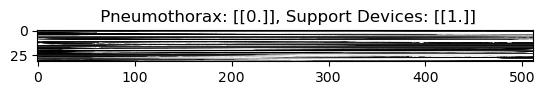

In [8]:
# Take one sample from the dataset
for images, y_labels, a_labels in dataset.take(1):
    # Assuming images are normalized between 0 and 1
    plt.imshow(images[:, :, 0], cmap='gray')  # Assuming it's a single grayscale image
    plt.title(f" Pneumothorax: {y_labels[0].numpy()}, Support Devices: {a_labels[0].numpy()}")
    plt.show()


NOTE: using repeat because I am running out of data

In [5]:
#@markdown Model parameters 
# Example dimensions for a 512x512 black and white image
n_pixels = 512
n_channels = 1

# Models

## Baseline model - SingleHead class
We build simple MLP models that predict one binary label. This model can be used to assess the performance of the baseline model f(X) -> Y.

## Attribute encoding - SingleHead with frozen feature extractor
In addition, this model can take as an extra input a frozen feature extractor. It then adds a linear layer to this feature extractor to perform the binary classification. Only the weights of this layer are tuned during training. This architecture is used to assess the level of attribute encoding of another model.

## Multi-task - MultiHead with Gradient Reversal
The architecture of the multi-task model first comprises a series of layers that represent a "feature extractor". On top of the feature extractor, we add two heads: 
- one head for the label, which is predicted from a single linear layer,
- one head for an auxiliary task (here the prediction of the color of the square). This head includes at least a non-linear layer to allow a gradient scaling operation.

The weight of the auxiliary loss in the total loss is a hyper-parameter in the method (weight of label loss is fixed to 1.0). A gradient reversal head is added to the auxiliary task. Gradient scaling can then be performed (positive or negative, extra hyper-parameter). Setting both hyper-parameters to 0 corresponds to the baseline single head model.


A config (`cfg`) dictionary specifies the parameters of the MLP architecture.

The provided code defines a set of utility classes for constructing machine learning models with TensorFlow, specifically focusing on models that might use a technique known as "Gradient Reversal" for tasks such as domain adaptation or fairness in machine learning, where a model needs to learn tasks while ignoring or reducing reliance on certain attributes.

### GradientReversal Class

- **Purpose**: Implements a custom TensorFlow layer that reverses the gradient during backpropagation. This is useful in scenarios where you want the model to learn representations that are invariant to certain attributes (e.g., sensitive demographic information) by penalizing the model for being able to predict these attributes.
- **Methods**:
  - `grad_reverse`: The core method that allows the layer to act as an identity function during the forward pass but reverses the gradient by a factor of `hp_lambda` during the backward pass.
  - `__init__`: Initializes the GradientReversal layer with a specified `hp_lambda` value, which determines how much the gradients are scaled during backpropagation.
  - `call`: Invokes the `grad_reverse` method as part of the forward pass.
  - `set_hp_lambda`, `increment_hp_lambda_by`, `get_hp_lambda`: Methods for adjusting the `hp_lambda` parameter, allowing dynamic modification of how strongly the gradients are reversed during training.

### BaselineArch Class

- **Purpose**: Serves as a superclass for building machine learning models. It provides methods for processing input data batches, fitting the model to data, making predictions, and evaluating model performance.
- **Key Features**:
  - Handling of inputs and outputs for the model, including the ability to work with auxiliary tasks.
  - A method for fitting the model on a TensorFlow dataset.
  - Prediction methods that can work with both individual inputs and batches from a TensorFlow dataset.
  - A scoring method to evaluate the model using a specified metric.

### MultiHead Class

- **Purpose**: Extends BaselineArch to support models with multiple output heads, allowing simultaneous training on a main task and one or more auxiliary tasks.
- **Key Features**:
  - Building of a multi-output model architecture with separate heads for the main and auxiliary tasks.
  - Integration of the GradientReversal layer to apply gradient reversal to the auxiliary task, aiding in learning invariant representations with respect to the auxiliary attribute.
  - Model compilation with specific loss functions, loss weights, and metrics for each output head.
  - Enhanced prediction and evaluation methods to handle multiple outputs.

### SingleHead Class

- **Purpose**: A simplified version of BaselineArch for models with a single output head. It can be used for straightforward tasks or for training a model on an auxiliary task using a pre-trained feature extractor.
- **Key Features**:
  - Option to build a model from scratch or utilize a pre-trained feature extractor for the main task.
  - Simplified architecture suitable for single-task learning scenarios.

These classes provide a flexible framework for experimenting with machine learning models in TensorFlow, particularly for research on fairness and domain adaptation where control over gradient flow and representation learning is crucial.

# Baseline task model

In [6]:
metric = tf.keras.metrics.AUC


baseline = []
seed= 0 
tf.random.set_seed(seed)
np.random.seed(seed)
enc = SingleHead(cfg, main="y", dtype=tf.float32, feat_extract=None)
kwargs = {'epochs': 100, 'steps_per_epoch':21, 'verbose': True}
enc.fit(train_data, **kwargs)
kwargs = {'verbose': True}
num_batches = 21
sc = enc.score(valid_data, num_batches, metric, **kwargs)
baseline.append(sc)

print("Baseline model: %1.2f +- %.2f" % (np.mean(baseline),np.std(baseline)))

Epoch 1/100
21/21 [==============================] - 3s 122ms/step - loss: 0.7131 - auc: 0.4490
Epoch 2/100
21/21 [==============================] - 2s 112ms/step - loss: 0.6943 - auc: 0.3470
Epoch 3/100
21/21 [==============================] - 2s 111ms/step - loss: 0.6970 - auc: 0.3517
Epoch 4/100
21/21 [==============================] - 2s 113ms/step - loss: 0.6598 - auc: 0.4788
Epoch 5/100
21/21 [==============================] - 2s 114ms/step - loss: 0.6945 - auc: 0.3702
Epoch 6/100
21/21 [==============================] - 2s 112ms/step - loss: 0.6253 - auc: 0.4158
Epoch 7/100
21/21 [==============================] - 2s 112ms/step - loss: 0.7068 - auc: 0.3358
Epoch 8/100
21/21 [==============================] - 2s 112ms/step - loss: 0.6686 - auc: 0.3503
Epoch 9/100
21/21 [==============================] - 2s 112ms/step - loss: 0.6900 - auc: 0.4103
Epoch 10/100
21/21 [==============================] - 2s 110ms/step - loss: 0.6693 - auc: 0.4577
Epoch 11/100
21/21 [===================

# Bounds on attribute encoding (i.e. LEB and UEB in paper)

In [ ]:
#@title Upper bound
metric = tf.keras.metrics.AUC

upper_bound = []
seed=0
tf.random.set_seed(seed)
np.random.seed(seed)
enc = SingleHead(cfg, main="a", dtype=tf.float32, feat_extract=None)
kwargs = {'epochs': 10, 'steps_per_epoch':21, 'verbose': False}
enc.fit(dataset, **kwargs)
kwargs = {'verbose': False}
num_batches = 10
sc = enc.score(dataset, num_batches, metric, **kwargs)
upper_bound.append(sc)

print("Upper bound: %1.2f +- %.2f" % (np.mean(upper_bound),np.std(upper_bound)))

Upper bound: 0.77 +- 0.00


In [ ]:
# Assuming num_batches is defined and matches the total batches available in your dataset
# Assuming your dataset is structured as (images, pneumothorax_labels, support_devices_labels)

num_batches = 21  # Adjust based on your specific batch count if necessary
batch_size = 32  # Your batch size
n_train = 672  # Total number of images in your dataset
a_dim = 1  # Assuming binary classification for either pneumothorax or support devices

lower_bound = []
#for seed in [0, 1, 2, 3, 4]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
a_true_all = np.array([]).reshape((0, a_dim))
a_pred_all = np.array([]).reshape((0, a_dim))

for batch in dataset.take(num_batches):
    # Unpack the batch according to your dataset structure
    images, pneumothorax_labels, support_devices_labels = batch
    
    # Dynamically determine the actual size of the current batch for pneumothorax_labels
    actual_batch_size = pneumothorax_labels.shape[0]
    
    # Extract the labels and ensure it's reshaped to 2D if necessary
    a_true = pneumothorax_labels.numpy()
    a_true = a_true.reshape(-1, a_true.shape[-2])
    
    # Simulate predictions: Adjust to use actual_batch_size
    a_pred = np.random.choice([0, 1], size=(actual_batch_size, a_dim))
    
    # Append the true labels and predictions to their respective accumulators
    a_true_all = np.append(a_true_all, a_true, axis=0)
    a_pred_all = np.append(a_pred_all, a_pred, axis=0)
# Calculate and store the AUC score for this iteration

sc = tf.keras.metrics.AUC()(a_true_all, a_pred_all).numpy()
lower_bound.append(sc)

# Print the lower bound score
print("Lower bound: %1.2f +- %.2f" % (np.mean(lower_bound), np.std(lower_bound)))


Lower bound: 0.54 +- 0.00


In [13]:
# Let's look at the shapes of each component in a single element (or batch) of the dataset
for images, pneumothorax_labels, support_devices_labels in dataset.take(1):
    print("Images shape:", images.shape)
    print("Pneumothorax labels shape:", pneumothorax_labels.shape)
    print("Support devices labels shape:", support_devices_labels.shape)
    break  # Only take the first element for inspection


Images shape: (32, 512, 512, 1)
Pneumothorax labels shape: (32, 1, 1)
Support devices labels shape: (32, 1, 1)


# Example of Multi-Task model

In [14]:
#@title Initialize from config
cfg.model.attr_grad_updates = float(0.1) # if both are set to 0, this is a baseline model (i.e. the same as with no extra head)
cfg.attr_loss_weight = float(0.75)
clf = MultiHead(cfg, main="y", aux="a", dtype=tf.float32, pos=None)

In [15]:
#@markdown Explore the architecture
clf.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 flatten_2 (Flatten)            (None, 262144)       0           ['input_3[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 10)           2621450     ['flatten_2[0][0]']              
                                                                                                  
 dense_7 (Dense)                (None, 10)           110         ['dense_6[0][0]']          

In [16]:
#@title Train the model
kwargs = {'epochs': 10, 'steps_per_epoch':2, 'verbose': True}
clf.fit(dataset, **kwargs)
clf.trainable=False

Epoch 1/10
2/2 [==============================] - 3s 943ms/step - loss: 7.6914 - output_loss: 6.3333 - attribute_loss: 1.8108 - output_auc_5: 0.0000e+00 - attribute_auc_6: 0.4036
Epoch 2/10
2/2 [==============================] - 2s 896ms/step - loss: 4.2505 - output_loss: 3.3973 - attribute_loss: 1.1376 - output_auc_5: 0.0000e+00 - attribute_auc_6: 0.5308
Epoch 3/10
2/2 [==============================] - 2s 780ms/step - loss: 0.8355 - output_loss: 0.3156 - attribute_loss: 0.6931 - output_auc_5: 0.5000 - attribute_auc_6: 0.5000
Epoch 4/10
2/2 [==============================] - 3s 2s/step - loss: 0.6297 - output_loss: 0.1098 - attribute_loss: 0.6932 - output_auc_5: 0.5000 - attribute_auc_6: 0.5000    
Epoch 5/10
2/2 [==============================] - 2s 740ms/step - loss: 0.6190 - output_loss: 0.0995 - attribute_loss: 0.6927 - output_auc_5: 0.4127 - attribute_auc_6: 0.5000
Epoch 6/10
2/2 [==============================] - 7s 3s/step - loss: 0.8124 - output_loss: 0.2934 - attribute_loss: 

In [17]:
#@title Define the decision threshold by maximizing the F1-score on validation data

from sklearn.metrics import precision_recall_curve
def f1_curve(truth, prediction_scores, e=1e-6):
  precision, recall, thresholds = precision_recall_curve(truth, prediction_scores)
  f1 = 2*recall*precision/(recall+precision+e)
  return thresholds, f1[:-1]

def threshold_at_max_f1_score(truth, prediction_scores):
  thresholds, f1 = f1_curve(truth, prediction_scores)
  peak_idx = np.argmax(f1)
  return thresholds[peak_idx]

In [19]:
kwargs = {'verbose': True}
num_batches = 2
metric = tf.keras.metrics.AUC
scores_val = clf.score(dataset, num_batches, metric, **kwargs)
print(scores_val)

1/1 [==============================] - 0s 42ms/step
[0.0, 0.5]


In [20]:
kwargs = {'verbose': False}
yt, yp = clf.predict_mult(dataset, num_batches, **kwargs)
threshold = threshold_at_max_f1_score(yt[0],yp[0])
threshold

/opt/itu/easybuild/software/Anaconda3/2023.03-1/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


0.0042333900928497314

In [21]:
#@title Fairness metrics

# As per the work of Alabdulmohsin et al., 2021

def fairness_metrics(y_pred, y_true, sens_attr):
  eps = 1e-5
  groups = np.unique(sens_attr).tolist()

  max_error = 0
  min_error = 1

  max_mean_y = 0
  min_mean_y = 1

  max_mean_y0 = 0  # conditioned on y = 0
  min_mean_y0 = 1

  max_mean_y1 = 0
  min_mean_y1 = 1

  for group in groups:
    yt = y_true[sens_attr == group].astype('int32')
    ypt = (y_pred[sens_attr == group]).astype('int32')
    err = -np.mean(yt * np.log(ypt+eps) + (1-yt)*np.log(1-ypt+eps))
    mean_y = np.mean(y_pred[sens_attr == group])
    neg = np.logical_and(sens_attr == group, y_true == 0)
    pos = np.logical_and(sens_attr == group, y_true == 1)
    mean_y0 = np.mean(y_pred[neg])
    mean_y1 = np.mean(y_pred[pos])

    if err > max_error:
      max_error = err
    if err < min_error:
      min_error = err

    if mean_y > max_mean_y:
      max_mean_y = mean_y
    if mean_y < min_mean_y:
      min_mean_y = mean_y

    if mean_y0 > max_mean_y0:
      max_mean_y0 = mean_y0
    if mean_y0 < min_mean_y0:
      min_mean_y0 = mean_y0

    if mean_y1 > max_mean_y1:
      max_mean_y1 = mean_y1
    if mean_y1 < min_mean_y1:
      min_mean_y1 = mean_y1
  
  eo = 0.5*(max_mean_y0 - min_mean_y0 + max_mean_y1 - min_mean_y1)
  dp = max_mean_y - min_mean_y
  err_parity = max_error - min_error

  return eo, dp, err_parity

The given Python function `fairness_metrics` computes three key fairness metrics based on predictions (`y_pred`), true labels (`y_true`), and a sensitive attribute (`sens_attr`). Here’s a brief explanation of what each of these metrics represents and how they're computed within the function:

### 1. **Equalized Odds (EO)**
Equalized Odds is computed as half the sum of the absolute differences between the maximum and minimum predicted probabilities for negative (`y=0`) and positive (`y=1`) outcomes across groups defined by the sensitive attribute. It measures whether the model's predictions are equally fair for all groups, both for those who do and do not actually have the condition (e.g., pneumothorax). A lower EO value indicates better fairness in terms of equal false positive and true positive rates across groups.

### 2. **Demographic Parity (DP)**
Demographic Parity is calculated as the difference between the maximum and minimum mean predicted probabilities across different groups. This metric assesses whether the model predicts the condition at an equal rate across all groups, regardless of the actual prevalence within those groups. A lower value of DP suggests that the model's predictions are not biased towards any particular group based on the sensitive attribute.

### 3. **Error Parity (Err Parity)**
Error Parity measures the difference between the maximum and minimum cross-entropy errors across groups. Cross-entropy error here is used to quantify how well the predicted probabilities align with the true labels, with a particular focus on how this alignment varies across groups defined by the sensitive attribute. A smaller difference indicates that the model's accuracy or error rate is consistent across different groups, contributing to overall fairness.

### Implementation Details
- The function iterates through each unique value of the sensitive attribute to calculate the metrics separately for each group.
- It uses cross-entropy error to evaluate model performance for each group, adjusting for potential issues with predicted probabilities being exactly 0 or 1 through a small epsilon value (`eps = 1e-5`).
- `max_error` and `min_error` track the highest and lowest errors across groups, respectively, used to calculate Error Parity.
- `max_mean_y`, `min_mean_y`, `max_mean_y0`, `min_mean_y0`, `max_mean_y1`, and `min_mean_y1` track the highest and lowest mean predicted probabilities across groups, for all cases, cases with true negative, and cases with true positive labels, respectively. These are used to calculate Demographic Parity and Equalized Odds.

### Usage
This function can be particularly useful for evaluating the fairness of medical diagnostic models (like those detecting pneumothorax from X-rays) with respect to a sensitive attribute such as patient age, gender, race, or the presence of interventions like chest drains. The metrics provide insights into whether the model's performance is equitable across groups, a crucial consideration for clinical applications to avoid exacerbating existing health disparities.

In [22]:
#@title Evaluate the model on test data
kwargs = {'verbose': False}
num_batches = 20
metric = tf.keras.metrics.AUC
scores = clf.score(dataset, num_batches, metric, **kwargs)
scores

[0.75968254, 0.5]

In [23]:
yt, yp = clf.predict_mult(dataset, num_batches, **kwargs)
eo, dp, ep = fairness_metrics(yp[0]>=threshold,
                              yt[0],yt[1].astype('int32'))

In [41]:
#@title Evaluate model on counterfactual test data
kwargs = {'verbose': False}
num_batches = 20
metric = tf.keras.metrics.AUC

scores_flipped = clf.score(dataset, num_batches,metric, **kwargs)
scores_flipped

[0.5, 0.5]

In [43]:
#@title Evaluate attribute encoding based on a frozen feature extractor from the multi-task model
enc = SingleHead(cfg, main="a", dtype=tf.float32, feat_extract=clf.feat_extract)
kwargs = {'epochs': 30, 'steps_per_epoch':20, 'verbose': True}
enc.fit(dataset, **kwargs)
kwargs = {'verbose': True}
num_batches = 20
metric = tf.keras.metrics.AUC
sc = enc.score(dataset, num_batches, metric, **kwargs)
sc

0.5

# Piecing the elements together: ShorT

In [24]:
#@title ShorT method
def shortcut_testing(cfg, train_data, test_data, counterfact_data, val_data,
                     range_grads, seeds = [0,1,2,3,4], num_epochs_train = 30,
                     num_batch_test = 5):
  """Shortcut testing.

  Requires:
  - cfg: a config dictionary of model specifications
  - train_data: tf dataset of train data respecting the positions for x,y,a
  - test_data: tf dataset of test data
  - counterfact_data: tf dataset of counterfactual test images
  - val_data: validation data to compute decision threshold
  - range_grads: np array of gradient scalings
  - seeds: list of seed numbers to fix, per gradient scaling
  - num_epoch_train: int, number of epochs for training
  - num_batch_test: number of batches to test the model on

  Outputs:
  scores_y: np array of size (# gradient scalings, # seeds) of test performance on Y
  encoding_a: np array of model's attribute encoding
  equ_odds: np array of equalized odds on test data
  dem_par: similar, demographic parity
  err_par: error parity
  count_fair: counterfactual fairness (computed locally then averaged)
  scores_c: global performance on Y on counterfactual data
  models: tf.Keras.model instances
  """ 


  scores_y = np.zeros((len(range_grads), len(seeds)))
  scores_c = np.zeros((len(range_grads), len(seeds)))
  encoding_a = np.zeros((len(range_grads), len(seeds)))
  equ_odds = np.zeros((len(range_grads), len(seeds)))
  dem_par = np.zeros((len(range_grads), len(seeds)))
  err_par = np.zeros((len(range_grads), len(seeds)))
  count_fair = np.zeros((len(range_grads), len(seeds)))
  models = []
  metric = tf.keras.metrics.AUC
  loss_weight = cfg.attr_loss_weight
  for g, grad_scaling in enumerate(range_grads):
    cfg.model.attr_grad_updates = float(grad_scaling)

    if grad_scaling == 0:  ## baseline model with no other head
      cfg.attr_loss_weight = float(0.0)
    else:
      cfg.attr_loss_weight = float(loss_weight)
    
    for s, seed in enumerate(seeds):
      tf.random.set_seed(seed)
      np.random.seed(seed)
      # instantiate
      clf = MultiHead(cfg, main="y", aux="a", dtype=tf.float32, pos=None)
      # train the multi-head model
      kwargs = {'epochs': num_epochs_train, 'steps_per_epoch':20, 'verbose': False}
      clf.fit(train_data, **kwargs)
      clf.trainable = False

      # estimate attribute encoding by freezing the weights of the feature extractor
      enc = SingleHead(cfg, main="a", dtype=tf.float32, feat_extract=clf.feat_extract)
      kwargs = {'epochs': num_epochs_train, 'steps_per_epoch':20, 'verbose': False}
      enc.fit(train_data, **kwargs)
      kwargs = {'verbose': False}
      encoding_a[g,s] = enc.score(test_data, num_batch_test,
                                  metric, **kwargs)

      # Model performance on test
      scores = clf.score(test_data, num_batch_test, metric, **kwargs)
      scores_y[g,s] = scores[0]

      # from validation data, obtain threshold for decision making
      out_true, out_pred = clf.predict_mult(val_data,
                                            num_batches=num_batch_test,
                                            **kwargs)
      threshold = threshold_at_max_f1_score(out_true[0],out_pred[0])

      # Model statistical fairness metric
      out_true, out_pred = clf.predict_mult(test_data, num_batches=num_batch_test, **kwargs)
      eo, dp, ep = fairness_metrics(out_pred[0]>=threshold,
                                    out_true[0],out_true[1].astype('int32'))
      equ_odds[g,s] = eo
      dem_par[g,s] = dp
      err_par[g,s] = ep
      # global shortcutting
      scores = clf.score(counterfact_data, num_batch_test, metric, **kwargs)
      scores_c[g,s] = scores[0]
      # counterfactual fairness metric
      cf_true, cf_pred = clf.predict_mult(counterfact_data, num_batches=num_batch_test,
                                          **kwargs)
      count_fair[g,s] = np.mean(np.abs(
          (out_pred[0]>=threshold).astype(float) - (cf_pred[0]>=threshold).astype(float)))
      models.append(clf)
      del clf
  return scores_y, encoding_a, equ_odds, dem_par, err_par, count_fair, scores_c, models

The `shortcut_testing` function implements the ShorT method, designed to evaluate machine learning models on multiple fronts, particularly focusing on their performance, fairness, and susceptibility to shortcut learning. Here's a breakdown of its key components and workflow:

### Inputs
- `cfg`: Configuration dictionary specifying model architecture, training parameters, and other settings.
- `train_data`, `test_data`, `counterfact_data`, `val_data`: TensorFlow datasets for training, testing, evaluating on counterfactual data, and validation, respectively. These datasets must include features (`x`), targets (`y`), and sensitive attributes (`a`).
- `range_grads`: An array of gradient scaling values to test. This allows the examination of how varying degrees of gradient reversal (applied to the sensitive attribute predictions) impact the model's learning and fairness metrics.
- `seeds`: A list of seed values for reproducibility.
- `num_epochs_train`: Number of epochs for training each model.
- `num_batch_test`: Number of batches to use for testing and evaluating fairness metrics.

### Workflow
1. **Initialization**: Arrays to store scores, fairness metrics, and models for each combination of gradient scaling and seed are initialized.
2. **Training Loop**: For each gradient scaling value:
   - Adjust the gradient scaling in the model configuration.
   - For each seed value:
     - Set the random seed for reproducibility.
     - Instantiate and train a multi-head model using the `MultiHead` class, with one head for the main task and another for the sensitive attribute, applying the specified gradient scaling.
     - Freeze the trained model and use it as a feature extractor to train a `SingleHead` model for estimating the encoding of the sensitive attribute.
     - Evaluate the multi-head model on the test dataset to get performance scores and on the validation dataset to determine the decision threshold for maximum F1 score.
     - Calculate fairness metrics (equalized odds, demographic parity, error parity) based on the predictions made using the decision threshold.
     - Evaluate the model's performance on counterfactual data and compute a counterfactual fairness metric.
     - Store the trained model for further analysis.

### Outputs
- `scores_y`: Performance of the models on the main task for each gradient scaling and seed.
- `encoding_a`: Estimated encoding of the sensitive attribute by the models.
- `equ_odds`, `dem_par`, `err_par`: Fairness metrics for each model.
- `count_fair`: Counterfactual fairness metric for each model.
- `scores_c`: Performance of the models on counterfactual data.
- `models`: List of trained model instances for further inspection or analysis.

This comprehensive approach allows for the examination of how different degrees of attention to a sensitive attribute (modulated through gradient scaling) impact a model's fairness and susceptibility to shortcut learning, offering insights into optimizing models for fairness while maintaining or improving performance.

In [40]:
#@title Run ShorT

# Ensure that these parameters cover the attribute encoding from LEB to UEB
range_grads = [-0.09, -0.07, -0.05, -0.03, -0.02, -0.01, -0.005,0.0, 0.005, 0.01, 0.02, 0.03, 0.05,0.07, 0.09]


# This should take some time to run
acc_y, acc_a, eo, dp, ep, cf, counter_y, models = shortcut_testing(cfg, dataset,
                                                      dataset, dataset,
                                                      dataset,
                                                      range_grads,
                                                      num_epochs_train=10,
                                                      num_batch_test=21, seeds= [0])


In [41]:
#@markdown Derive the correlation

filt = acc_y >= 0.8  #@param User-defined performance threshold. The goal is to discard trivial models
corr, p = scipy.stats.spearmanr(acc_a[filt],cf[filt])
print(corr)
print(p)


nan
nan


/opt/itu/easybuild/software/Anaconda3/2023.03-1/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [42]:
#@title Plot utils

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

palette = sns.color_palette('tab20b')

def plot_scale_gradients_encoding(scale_gradients, encoding_a, 
                                  upper_bound, lower_bound):
  """Plots the intervention compared to attribute encoding.

  Inputs:
  scale_gradients: numpy array of scale gradients used
  encoding_a: numpy array of attribute encoding values, as measure by transfer learning
  upper_bound: list or numpy array of maximum attribute encoding
  lower_bound: list or numpy array of minimum attribute encoding
  """
  
  sg_mean = np.mean(encoding_a, axis=1)
  sg_std = np.std(encoding_a, axis=1)

  fig = plt.figure(figsize=(5,4))
  ax = fig.add_axes([0,0,1,1])
  ax.errorbar(scale_gradients, sg_mean, 
                yerr=sg_std, 
                fmt='x', 
                color='tab:blue',
                ecolor='tab:blue')
  plt.hlines(np.mean(upper_bound),np.min(scale_gradients), np.max(scale_gradients),
            colors=[0.4,0.4,0.4],linestyles='dashed')
  plt.hlines(np.mean(lower_bound),np.min(scale_gradients), np.max(scale_gradients),
            colors=[0.4,0.4,0.4],linestyles='dashed')
  ax.set_xlabel('Scale Gradient')
  ax.set_ylabel('Attribute encoding')
  plt.show

def plot_fairness_encoding(encoding_m, fair_m, perf_m, perf_thresh = 0):
  """Plots fairness results vs attribute encoding.
  
  Inputs:
  encoding_m: encoding metric result, as numpy array
  fair_m: fairness metric result, as numpy array
  perf_m: model performance on the output label, as numpy array
  perf_thresh: what minimum performance to consider
  """

  filt = perf_m <= perf_thresh

  fig = plt.figure(figsize=(5,4))
  plt.scatter(encoding_m, fair_m,color=[0.6,0,0.2],alpha=0.5)
  plt.scatter(encoding_m[filt], fair_m[filt],color=[0.2,0.2,0.2])
  plt.xlabel('Attribute Accuracy')
  plt.ylabel('Fairness')
  plt.show()

def point_z_order(c, midpoint):
  deviation = np.zeros_like(c)
  for i in range(c.shape[0]):
    if c[i] > midpoint:
      deviation[i] = (c[i]-midpoint) / (np.max(c)-midpoint)
    else:
      deviation[i] = (midpoint-c[i]) / (midpoint-np.min(c))
  return np.argsort(deviation)

def performance_fairness_age_frontier_plot(encoding_m, fair_m, perf_m,
                                           scale_gradients, cmap='PRGn'):
  
  class MidpointNormalize(mpl.colors.Normalize):
    """
    class to help renormalize the color scale
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

  baseline_models = np.argwhere(np.array(scale_gradients)==0.0)[0]
  if baseline_models.shape[0] == 0:
    baseline_models = int(len(scale_gradients)/2)
  midpoint = encoding_m[baseline_models,:].mean()
  baseline_model_perf = perf_m[baseline_models,:].mean()
  baseline_model_fair = fair_m[baseline_models,:].mean()

  print(f'Baseline model Attribute encoding: {midpoint:.2f}')
  print(f'Baseline model Performance: {baseline_model_perf:.4f}')
  print(f'Baseline model Fairness: {baseline_model_fair:.4f}')

  norm =  MidpointNormalize(midpoint = midpoint)

  attr = encoding_m.flatten()
  z_order = point_z_order(attr, midpoint)

  fair =fair_m.flatten()
  perf = perf_m.flatten()
  fig = plt.figure(figsize=(5,4))
  ax = fig.add_axes([0,0,1,1])
  plt.scatter(fair[z_order], perf[z_order], s=30, c=attr[z_order], cmap=cmap, norm=norm)
  # overplot the baseline models in red
  plt.scatter(fair_m[baseline_models,:], perf_m[baseline_models,:], s=30,
                   color=(0.8, 0.2, 0.2))
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),label='Attribute Encoding')
  plt.ylabel('Performance')
  plt.xlabel('Fairness')
  plt.show()

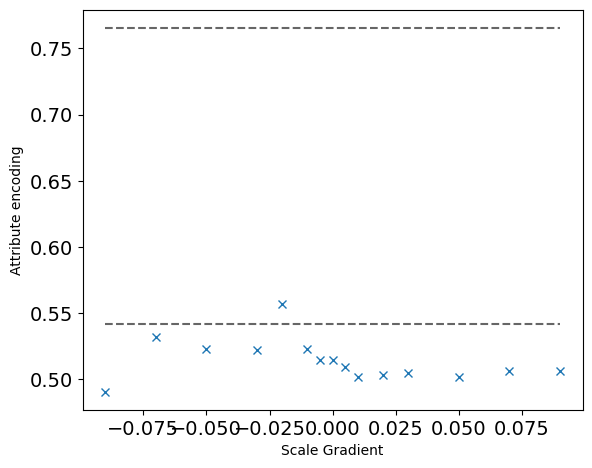

In [43]:
#@title Plot scale gradient vs age encoding
plot_scale_gradients_encoding(range_grads, acc_a, upper_bound, lower_bound)

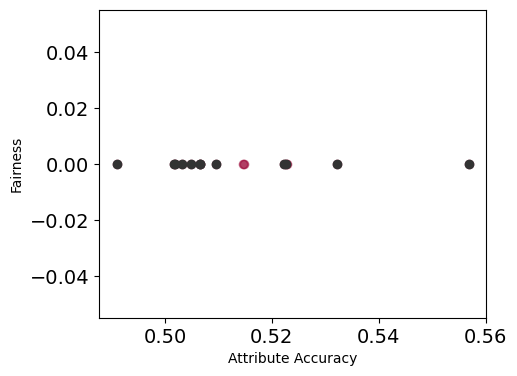

In [44]:
#@title Plot Fairness w.r.t. attribute encoding
#suffix = "{}_EO".format(cfg_data.corr_a_y1)
plot_fairness_encoding(acc_a, cf, acc_y, perf_thresh = 0.8)

Baseline model Attribute encoding: 0.51
Baseline model Performance: 0.8678
Baseline model Fairness: 0.2833


/tmp/ipykernel_38913/1052147022.py:113: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),label='Attribute Encoding')


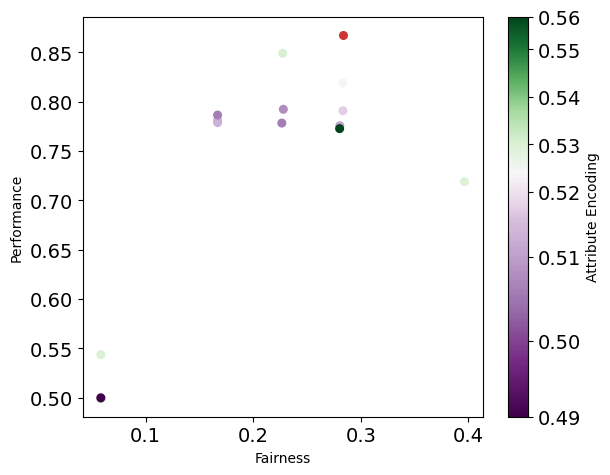

In [45]:
#@title Pareto plot of fairness-performance colored by attribute encoding
performance_fairness_age_frontier_plot(acc_a,eo,acc_y,range_grads)



In [48]:
#@title Selecting a model and dropping the attribute head for deployment

fairness_threshold = 0.09 #@param
gradient_parameters = np.array(range_grads).reshape(-1,1).repeat(5,axis=1)

possible_models = acc_y[eo<=fairness_threshold]
possible_gradients = gradient_parameters[eo<=fairness_threshold]
filt = eo<=fairness_threshold

ind = np.argmax(possible_models)
selected_gradient = float(possible_gradients[ind])
selected_model = models[np.argwhere(filt.flatten()).tolist()[ind][0]]
print("Selected gradient parameter: {}".format(selected_gradient))
print("Selected model performance: {}".format(possible_models[ind]))
print("Selected model fairness: {}".format(eo[eo<=fairness_threshold][ind]))

IndexError: boolean index did not match indexed array along dimension 1; dimension is 5 but corresponding boolean dimension is 1

In [47]:
selected_model.model.summary()

NameError: name 'selected_model' is not defined

In [ ]:
# Create a new model by selecting all layers except the ones related to the attribute
remove = ['attribute', 'attr_branch', 'gradient']  # corresponds to the names of the layer (partial matches ok), as defined in the MultiHead class

final_model = tf.keras.Sequential()
for layer in clf.model.layers:
  match = [to_pop in layer.name for to_pop in remove]
  if not any(match):
    final_model.add(layer)
    layer.trainable = False


In [ ]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 2352)              0         
                                                                 
 dense_30 (Dense)            (None, 10)                23530     
                                                                 
 dense_31 (Dense)            (None, 10)                110       
                                                                 
 dense_32 (Dense)            (None, 10)                110       
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 23,761
Trainable params: 0
Non-trainable params: 23,761
_________________________________________________________________


In [ ]:
x = test_dataset['train']['image']
y_pred = final_model.predict_on_batch(x)

In [ ]:
sklearn.metrics.roc_auc_score(test_dataset['train']['label'], y_pred)

0.8332877499999999